In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
pd.set_option('display.max_columns', 500)

#ML Models
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from google.colab import files
import os
import io
import matplotlib.pyplot as plt
import seaborn as sns
uploaded = files.upload()

Saving energy_dataset.csv to energy_dataset.csv
Saving weather_features.csv to weather_features.csv


In [5]:
energydf=pd.read_csv(io.BytesIO(uploaded['energy_dataset.csv']), parse_dates=True, index_col=0)
wdf = pd.read_csv(io.BytesIO(uploaded['weather_features.csv']), parse_dates=True)

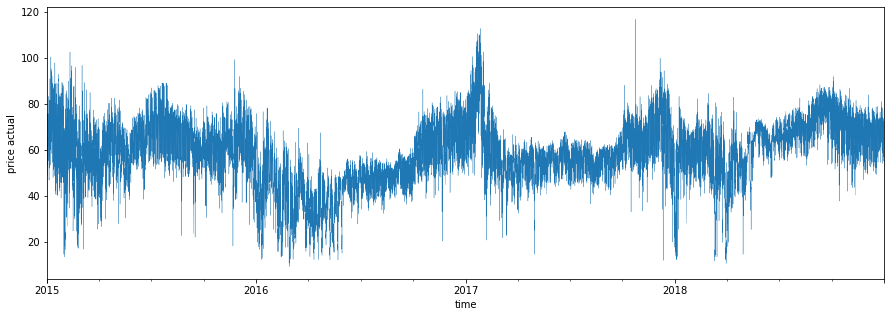

In [6]:
energydf.index = pd.to_datetime(energydf.index, infer_datetime_format=True, utc=True)
#Function for separating datetime into new columns
def separate_date(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day of week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['day of year'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    return df

energydf = separate_date(energydf)

#Visualise actual price variation over time
plt.figure(figsize=(15,5))
energydf['price actual'].plot(kind='line', lw=0.3)
plt.ylabel('price actual')
plt.show()

In [7]:
#Create new columns for total power generation and total forecasted generation
generation = ['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore']

forecast = ['forecast solar day ahead','forecast wind offshore eday ahead', 
            'forecast wind onshore day ahead']

energydf['generation'] = energydf[generation].sum(axis=1)
energydf['forecast'] = energydf[forecast].sum(axis=1)

energydf = energydf.drop(generation, axis=1).copy()
energydf = energydf.drop(forecast, axis=1).copy()

In [8]:
#Fill NaN values using the bfill method
energydf['total load actual'] = energydf['total load actual'].fillna(method='bfill')

In [9]:
#Check that all null values have been addressed
energydf.isna().sum()

total load forecast    0
total load actual      0
price day ahead        0
price actual           0
year                   0
month                  0
day of week            0
hour                   0
day of year            0
quarter                0
generation             0
forecast               0
dtype: int64

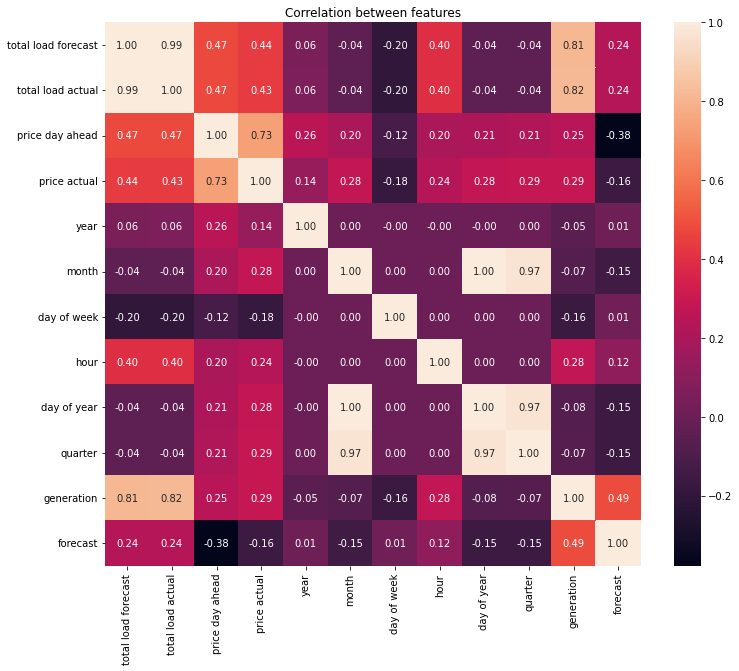

In [10]:
plt.figure(figsize=(12,10))
hm = sns.heatmap(energydf.corr(), annot=True, fmt="0.2f")
hm.set_title('Correlation between features')
plt.show()

#Create train and test sets
X_cols = ['total load forecast', 'total load actual',
       'price actual', 'year', 'month', 'day of week', 'hour', 'day of year',
       'quarter', 'generation', 'forecast']

y_cols = ['price day ahead']

#I will use values before 2018 as the training set and values after 2018 for testing
X_train = energydf.query('year<2018')[X_cols]
y_train = energydf.query('year<2018')[y_cols]

X_test = energydf.query('year>=2018')[X_cols]
y_test = energydf.query('year>=2018')[y_cols]

In [11]:
#Creating an XGBoost model and tuning hyperparameters
scores=[]
rates=[0.01,0.07,0.1,0.2]
for i in rates:
    xg_reg_test = xgb.XGBRegressor(learning_rate=i, n_estimators = 500)
    xg_reg_test.fit(X_train,y_train)
    preds_test = xg_reg_test.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
    scores.append(rmse_test)

[23:49:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:49:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [12]:
#Best score came from a combination of learning rate = 0.1 and n_estimators=500
print(dict(zip(rates,scores)))

{0.01: 9.105113485683962, 0.07: 8.408889021858922, 0.1: 8.375880612791917, 0.2: 8.31351352713706}


In [13]:
#Creating the final model
xg_reg=xgb.XGBRegressor(learning_rate=0.1, n_estimators=500)

xg_reg.fit(X_train, y_train)

preds=xg_reg.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, preds))

print(f'Root mean squared error: ',rmse)

[23:50:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root mean squared error:  8.375880612791917


In [14]:
#Creating df with actual values, predicted values, and delta
y_test['preds'] = preds
y_test['delta'] = y_test['price day ahead'] - y_test['preds']
y_test

,price day ahead,preds,delta
time,,,
2018-01-01 00:00:00+00:00,4.74,29.294159,-24.554159
2018-01-01 01:00:00+00:00,3.66,23.895473,-20.235473
2018-01-01 02:00:00+00:00,2.30,33.792168,-31.492168
2018-01-01 03:00:00+00:00,2.30,40.553535,-38.253535
2018-01-01 04:00:00+00:00,2.06,39.245178,-37.185178
...,...,...,...
2018-12-31 18:00:00+00:00,68.85,65.420189,3.429811
2018-12-31 19:00:00+00:00,68.40,64.808861,3.591139
2018-12-31 20:00:00+00:00,66.88,63.077408,3.802592


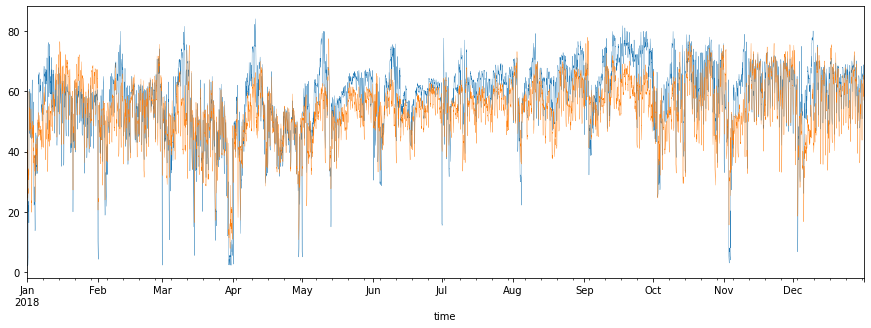

In [15]:
#Let's visualise predicted values against actual values
plt.figure(figsize=(15,5))
y_test['price day ahead'].plot(kind='line', lw=0.3)
y_test['preds'].plot(kind='line', lw=0.3)
plt.show()